# New York City Taxi Fare Prediction Case Study

## Working with tabular data
Deep learning with neural networks is often associated with sophisticated image recognition, and in upcoming sections we'll train models based on properties like pixels patterns and colors.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have developed on our own. However, to do this we have to handle categorical values separately from continuous ones. Make sure to watch the theory lectures! You'll want to be comfortable with:
* continuous vs. categorical values
* embeddings
* batch normalization
* dropout layers

## Perform standard imports

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this case study we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

Let's get started!

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/abhisheksinghblr/datasets/master/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Add a datetime column and derive useful statistics
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [7]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [8]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [9]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Separate categorical from continuous columns

In [10]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [11]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

<div class="alert alert-info"><strong>NOTE:</strong> If you plan to use all of the columns in the data table, there's a shortcut to grab the remaining continuous columns:<br>
<pre style='background-color:rgb(217,237,247)'>cont_cols = [col for col in df.columns if col not in cat_cols + y_col]</pre>

Here we entered the continuous columns explicitly because there are columns we're not running through the model (pickup_datetime and EDTdate)</div>


## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [12]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [13]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

We can see that <tt>df['Hour']</tt> is a categorical feature by displaying some of the rows:

In [14]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values <em>also</em> correspond to the codes assigned to each name.

We can access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This will make more sense if we look at <tt>df['AMorPM']</tt>:

In [15]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [16]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [17]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [18]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [19]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [20]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info"><strong>NOTE:</strong> This can be done in one line of code using a list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)</pre>

Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.</div>


## Convert numpy arrays to tensors

In [21]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [22]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [23]:
conts.type()

'torch.FloatTensor'

In [24]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [25]:
cats.shape

torch.Size([120000, 3])

In [26]:
conts.shape

torch.Size([120000, 6])

In [27]:
y.shape

torch.Size([120000, 1])

## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [28]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this case study our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the embeddings steps</strong> (this code is for illustration purposes only.)</div>

In [29]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [30]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [31]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [32]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [33]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.4651, -0.0741,  2.2431,  1.5258, -1.3511,  0.6639, -0.8778, -0.9482,
          -0.2363, -0.2897, -0.9079,  0.6044],
         [ 0.3112, -0.4272, -1.5157,  0.0538, -1.4275, -0.4995, -1.0026,  1.1366,
           0.4869, -1.3777,  0.8904, -0.0200],
         [ 0.7121, -0.2144,  0.9062, -0.3360,  0.4656,  0.5395,  0.4042,  1.0734,
           0.7071,  2.3189,  0.6163,  0.3333],
         [ 0.0961,  0.5495, -0.5613,  0.6416, -0.1779, -0.6776,  0.5352,  0.1225,
           0.9606,  1.2698,  1.3641,  0.9205]], grad_fn=<EmbeddingBackward>),
 tensor([[0.2478],
         [0.2478],
         [0.2478],
         [0.2905]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.9868,  1.2591,  0.1700,  0.6354],
         [-1.4630,  1.1411,  0.6974,  0.2766],
         [-1.4630,  1.1411,  0.6974,  0.2766],
         [ 1.3314, -0.3133, -0.4982, -1.3231]], grad_fn=<EmbeddingBackward>)]

In [34]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-0.4651, -0.0741,  2.2431,  1.5258, -1.3511,  0.6639, -0.8778, -0.9482,
         -0.2363, -0.2897, -0.9079,  0.6044,  0.2478, -0.9868,  1.2591,  0.1700,
          0.6354],
        [ 0.3112, -0.4272, -1.5157,  0.0538, -1.4275, -0.4995, -1.0026,  1.1366,
          0.4869, -1.3777,  0.8904, -0.0200,  0.2478, -1.4630,  1.1411,  0.6974,
          0.2766],
        [ 0.7121, -0.2144,  0.9062, -0.3360,  0.4656,  0.5395,  0.4042,  1.0734,
          0.7071,  2.3189,  0.6163,  0.3333,  0.2478, -1.4630,  1.1411,  0.6974,
          0.2766],
        [ 0.0961,  0.5495, -0.5613,  0.6416, -0.1779, -0.6776,  0.5352,  0.1225,
          0.9606,  1.2698,  1.3641,  0.9205,  0.2905,  1.3314, -0.3133, -0.4982,
         -1.3231]], grad_fn=<CatBackward>)

In [35]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [36]:
z = selfembdrop(z)
z

tensor([[-0.7752, -0.1235,  0.0000,  2.5431, -2.2518,  1.1064, -1.4630, -0.0000,
         -0.0000, -0.4828, -1.5131,  0.0000,  0.4131, -1.6447,  0.0000,  0.0000,
          1.0591],
        [ 0.0000, -0.7121, -2.5261,  0.0897, -0.0000, -0.0000, -0.0000,  0.0000,
          0.8115, -2.2962,  1.4839, -0.0000,  0.4131, -2.4383,  1.9019,  1.1623,
          0.0000],
        [ 0.0000, -0.3574,  0.0000, -0.0000,  0.7760,  0.8992,  0.6737,  1.7891,
          0.0000,  0.0000,  1.0272,  0.0000,  0.0000, -2.4383,  1.9019,  0.0000,
          0.0000],
        [ 0.0000,  0.9158, -0.9356,  0.0000, -0.2964, -1.1293,  0.8921,  0.2041,
          1.6011,  2.1164,  0.0000,  0.0000,  0.4842,  2.2191, -0.5221, -0.8303,
         -0.0000]], grad_fn=<MulBackward0>)

<div class="alert alert-danger"><strong>This is how the categorical embeddings are passed into the layers.</strong></div>

In [37]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [38]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [39]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Define loss function & optimizer
PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

In [40]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [41]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [42]:
len(cat_train)

48000

In [43]:
len(cat_test)

12000

## Train the model
Expect this to take 30 minutes or more! We've added code to tell us the duration at the end.

In [44]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.56901932
epoch:  26  loss: 10.90558434
epoch:  51  loss: 10.22915649
epoch:  76  loss: 9.74718189
epoch: 101  loss: 9.19717121
epoch: 126  loss: 8.42064381
epoch: 151  loss: 7.40450668
epoch: 176  loss: 6.24154758
epoch: 201  loss: 5.04079294
epoch: 226  loss: 4.22758293
epoch: 251  loss: 3.88620496
epoch: 276  loss: 3.75811219
epoch: 300  loss: 3.72330475

Duration: 988 seconds


## Plot the loss function

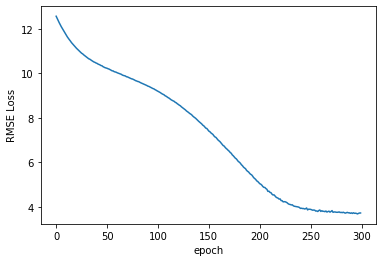

In [45]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [46]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.62290311


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [47]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.0766   2.9000   1.1766
 2.  14.3625   5.7000   8.6625
 3.   6.9594   7.7000   0.7406
 4.  14.3731  12.5000   1.8731
 5.   5.7729   4.1000   1.6729
 6.   5.4790   5.3000   0.1790
 7.   4.7132   3.7000   1.0132
 8.  20.0109  14.5000   5.5109
 9.   9.3687   5.7000   3.6687
10.  12.6962  10.1000   2.5962
11.   7.8680   4.5000   3.3680
12.   1.1454   6.1000   4.9546
13.   6.5607   6.9000   0.3393
14.  10.9017  14.1000   3.1983
15.   4.9935   4.5000   0.4935
16.  31.7028  34.1000   2.3972
17.   1.0579  12.5000  11.4421
18.   5.9378   4.1000   1.8378
19.   7.2638   8.5000   1.2362
20.   3.9069   5.3000   1.3931
21.  14.7151  11.3000   3.4151
22.   9.6016  10.5000   0.8984
23.  17.4127  15.3000   2.1127
24.  16.9119  14.9000   2.0119
25.  45.6295  49.5700   3.9405
26.   1.7769   5.3000   3.5231
27.   4.8839   3.7000   1.1839
28.   4.4926   6.5000   2.0074
29.  14.5391  14.1000   0.4391
30.   6.3440   4.9000   1.4440
31.   4.5239   3.7000   0.8239
32.  32.

So while many predictions were off by a few cents, some were off by \\$19.00. Feel free to change the batch size, test size, and number of epochs to obtain a better model.

## Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [48]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [49]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). 

In [50]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [51]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [52]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

## Feed new data through the trained model
For convenience, here are the max and min values for each of the variables:
<table style="display: inline-block">
<tr><th>Column</th><th>Minimum</th><th>Maximum</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>

<strong>Use caution!</strong> The distance between 1 degree of latitude (from 40 to 41) is 111km (69mi) and between 1 degree of longitude (from -73 to -74) is 85km (53mi). The longest cab ride in the dataset spanned a difference of only 0.243 degrees latitude and 0.284 degrees longitude. The mean difference for both latitude and longitude was about 0.02. To get a fair prediction, use values that fall close to one another.

In [ ]:
z = test_data(model2)